In [2]:
import autograd.numpy as np
from autograd import grad, hessian
import colorsys
import json
import matplotlib.pyplot as plt
import numpy as np2
from numpy.random import multivariate_normal as mvn
import pandas as pd
import random as ran
import ternary
from scipy.optimize import minimize
import seaborn as sns
from scipy.stats import norm



## Load Tags from Dataset

In [3]:
class tagClass:
    """Class to store each tag coordinate data."""
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    # Get functions
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    # Returns coordinates for 16 x 16 crop around tag centre
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [4]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [5]:
def getTags(rawData, nType):
    """Process raw data into objects of Tag class."""
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

In [6]:
def getPhoto(tag: tagClass):
    """Returns the image this tag is from."""
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

In [7]:
def getSnipPlot(tag):
    """Return a 16 x 16 pixel crop in the image for this tag."""
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo[tagY:tagY2,tagX:tagX2].astype(np.float32)

In [8]:
def getBayer(x, y):
    """Find Bayer filter pixel colour for given coordinate."""
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [9]:
def getPixels(t: tuple, photo):
    """Returns RGB values for this tag as ratio."""
    tagX, tagX2, tagY, tagY2 = t
    red = 0
    green = 0
    blue = 0
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                red += int(photo[py, px])
            elif col == 'G':
                green += int(photo[py, px])
            else:
                blue += int(photo[py, px])
    totalSum = red + (0.5*green) + blue
    return red/totalSum, (0.5*green)/totalSum, blue/totalSum

In [10]:
tags = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
allTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in tags:
    # Get data for each tag in data
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    allTags.loc[len(allTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

Text(0, 0.5, 'Pixels')

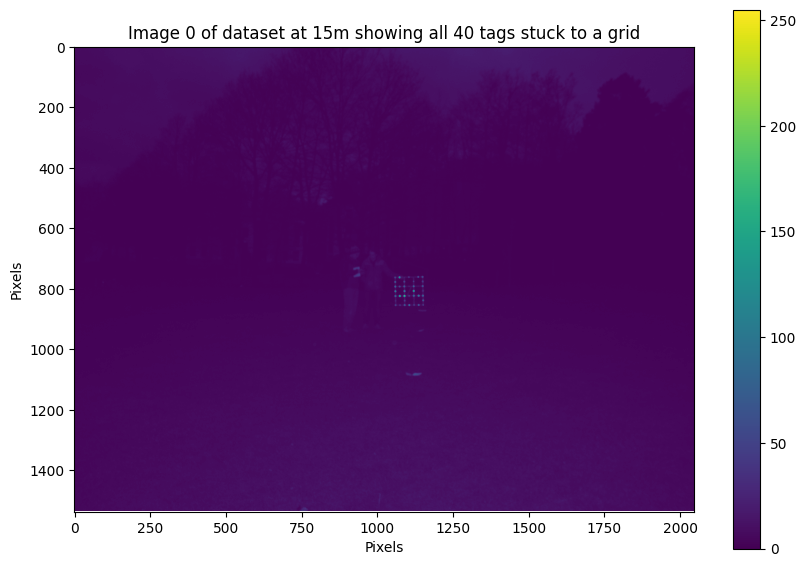

In [11]:
tag_number = 0
plt.figure(figsize=(10,7))
plt.imshow(getPhoto(allTags['Tag'][tag_number]))
plt.colorbar()
plt.title(f"Image {tag_number} of dataset at 15m showing all 40 tags stuck to a grid")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

## Colour Function Optimisation

In [12]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    """Simulate pixel value given its distance from the tag centre."""
    dist = np.sqrt(np.sum((tagCoord - pixelCoord)**2))
    # If outside tag width:
    if dist>psfWidth+0.5:
           return bgBrightness
    
    # If inside tag width:
    elif dist<psfWidth-0.5:
        return tagBrightness
    
    # If on the edge of the tag:
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))

def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    """Call simulate for each pixel in given image."""
    pixel_value_guesses = []

    # Loop over pixel coords for each colour...
    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # Get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # Call simulate_pixel with the coords of the pixel
            # and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord,
                                                      t[colour], b[colour], psfWidth))
    return np.array(pixel_value_guesses).astype(np.float32)

def cost_function(params, psfWidth, trueImg):
    """Returns the sum squared error of predicted pixel values compared
    to the true image."""
    tagCoord = params[:2]
    tagBright = params[2:5]
    bgBright = params[5:]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright,
                                         psfWidth, trueImg.shape)
    # Sum square error over all the pxiels between the true image
    # and the simulated image
    square_error = 0.01*np.sum([(s - a)**2 for (s, a) in zip(pixel_value_guesses,
                                                             trueImg.flatten())])
    return square_error

In [13]:
np.set_printoptions(precision=2, suppress=True)

In [14]:
realImg = getSnipPlot(allTags['Tag'].iloc[0])
cost_function(np.array([0, 0, 12, 14, 5, 4, 6, 5]), 3, realImg)

np.float32(694.45905)

In [15]:
params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])

In [16]:
def temp(p):
  return cost_function(p, 2.5, realImg)
grad(temp)(params)

array([ -38.73, -283.43,    1.63,    3.48,   -3.46,   -8.17,   -0.74,
         -5.9 ])

In [17]:
res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
               bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))

C:\Users\bencl\AppData\Local\Temp\ipykernel_24580\2860797999.py:1: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


In [18]:
grad(temp)(res.x)

array([-0.01, -0.  ,  0.  , -0.  , -0.  , -0.  , -0.01, -0.01])

In [19]:
hess = hessian(temp)(res.x)
[print("%0.5f" % a) for a in np.diag(hess)]

494.54589
482.71990
0.08750
0.16954
0.08735
1.15813
2.34227
1.16617


[None, None, None, None, None, None, None, None]

In [20]:
ci = np.sqrt(np.diag(np.linalg.inv(hess)))*1.96
names = ['x', 'y', 'r', 'g', 'b', 'bg_r', 'bg_g', 'bg_b']
[print("%7s: %0.5f-%0.5f" % (n, a, b)) for n, a, b in zip(names, res.x-ci, res.x+ci)]

      x: 8.09048-8.27301
      y: 8.57453-8.75676
      r: 89.48971-102.80756
      g: 27.23902-36.78710
      b: 58.11339-71.52887
   bg_r: 9.80620-13.46029
   bg_g: 3.19410-5.75948
   bg_b: 4.98862-8.63240


[None, None, None, None, None, None, None, None]

## Running Cost Function on All Tag_0 Images

In [21]:
onlyTag0 = allTags.loc[allTags['Label']==0]
onlyTag0.reset_index(inplace=True)

In [22]:
def getOnlyColour(c, guess, values):
    """Returns values in image for pixels with given colour in Bayer filter."""
    singleColour = np.zeros_like(values)
    singleColourReal = np.zeros_like(values)
    for x in range(values.shape[0]):
        for y in range(values.shape[1]):
            if getBayer(x, y) == c:
                singleColour[x, y] = guess[x, y]
                singleColourReal[x, y] = values[x, y]
            else:
                singleColour[x, y] = 0
                singleColourReal[x, y] = 0
    return singleColour, singleColourReal

C:\Users\bencl\AppData\Local\Temp\ipykernel_24580\1686454686.py:7: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


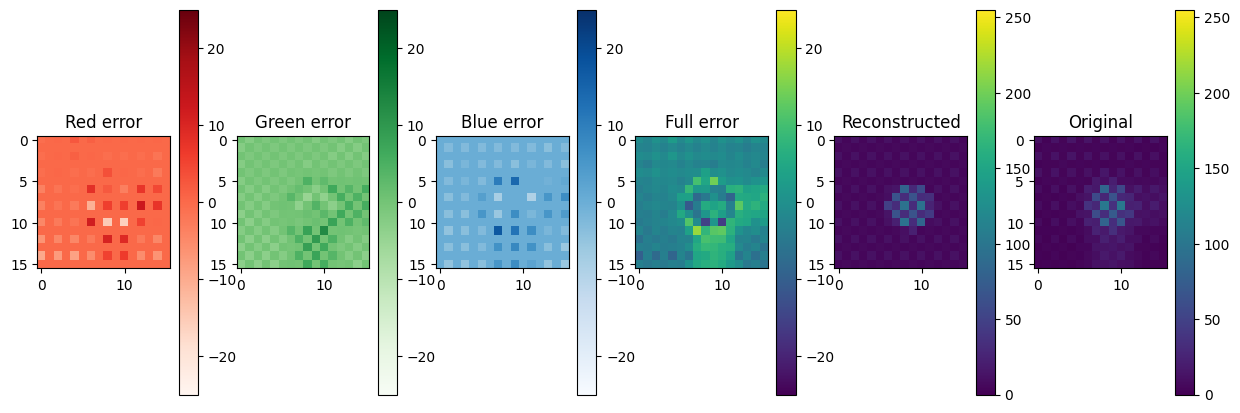

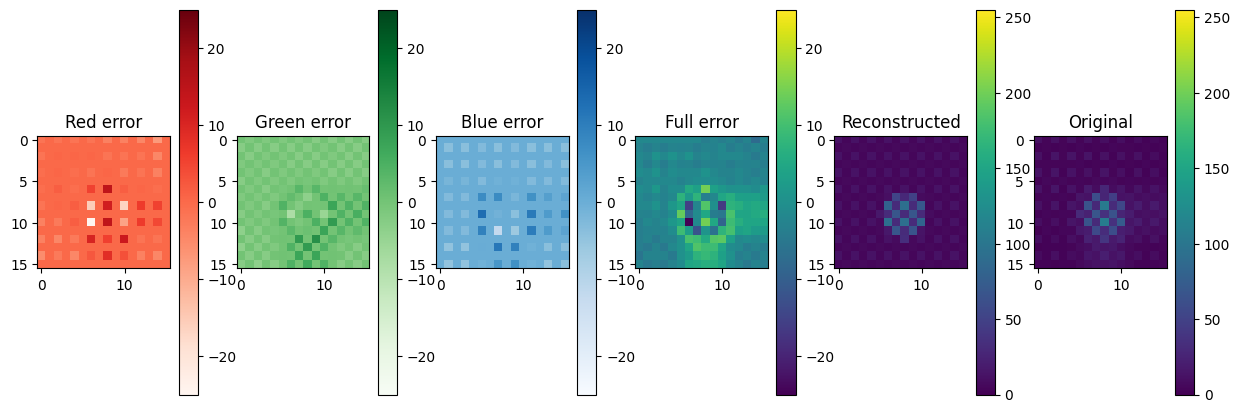

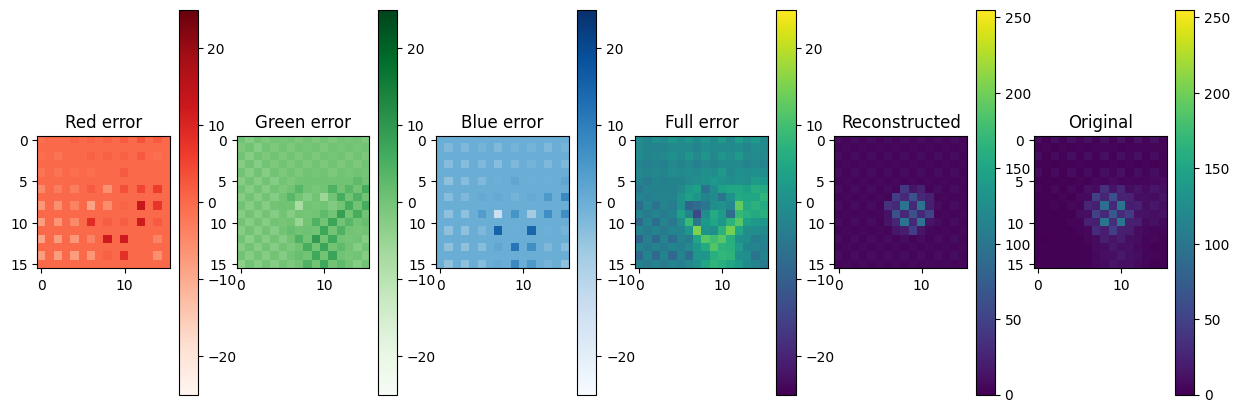

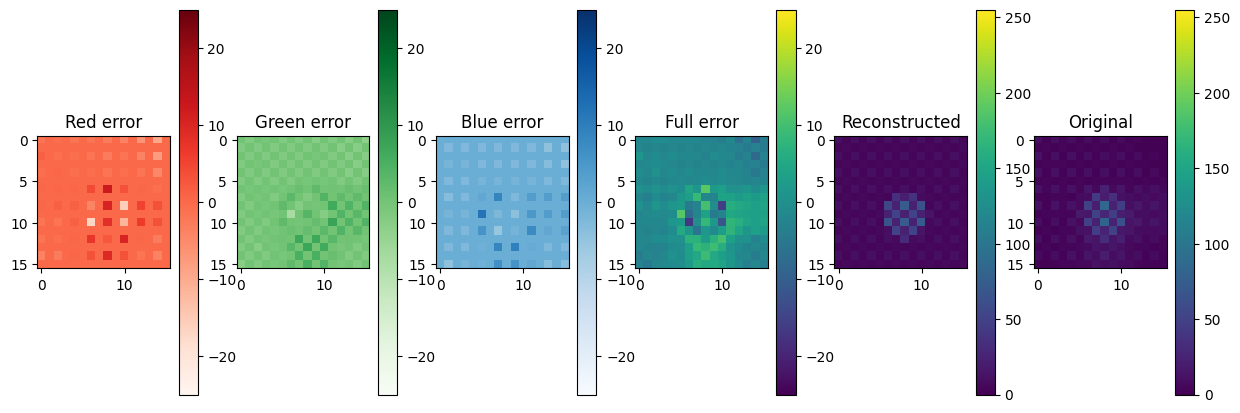

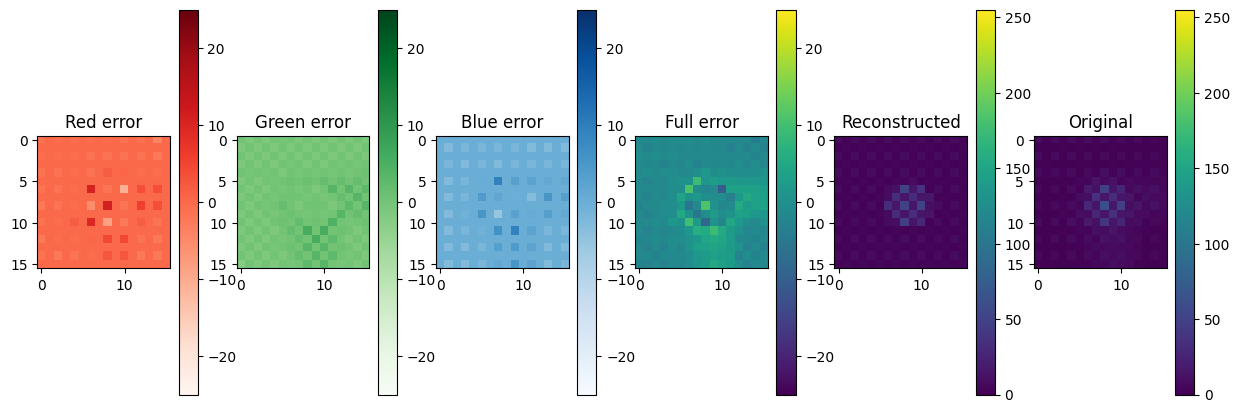

In [23]:
tag0HessInv = []
tag0X = []

for i in range(onlyTag0.shape[0]):
    realImg = getSnipPlot(onlyTag0['Tag'].iloc[i])
    params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
    res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
    pred = np.array(simulate_image(res.x[:2], res.x[2:5], res.x[5:], 2.6, [16,16])).reshape([16,16])
    
    tag0HessInv.append(hessian(temp)(res.x))
    tag0X.append(res.x)

    # Plot error per colour channel
    redGuess, red = getOnlyColour('R', pred, realImg)
    greenGuess, green = getOnlyColour('G', pred, realImg)
    blueGuess, blue = getOnlyColour('B', pred, realImg)
    
    plt.figure(figsize=[15,5])
    plt.subplot(1,6,1)
    plt.imshow(np.array(red - redGuess), clim=[-25,25], cmap='Reds')
    plt.colorbar()
    plt.title("Red error")

    plt.subplot(1,6,2)
    plt.imshow(np.array(green - greenGuess), clim=[-25,25], cmap='Greens')
    plt.colorbar()
    plt.title("Green error")

    plt.subplot(1,6,3)
    plt.imshow(np.array(blue - blueGuess), clim=[-25,25], cmap='Blues')
    plt.colorbar()
    plt.title("Blue error")

    plt.subplot(1,6,4)
    plt.imshow(np.array(realImg - pred), clim=[-25,25])
    plt.colorbar()
    plt.title("Full error")

    plt.subplot(1,6,5)
    plt.imshow(pred, clim=[0,255])
    plt.colorbar()
    plt.title("Reconstructed")

    plt.subplot(1,6,6)
    plt.imshow(realImg, clim=[0,255])
    plt.colorbar()
    plt.title("Original")

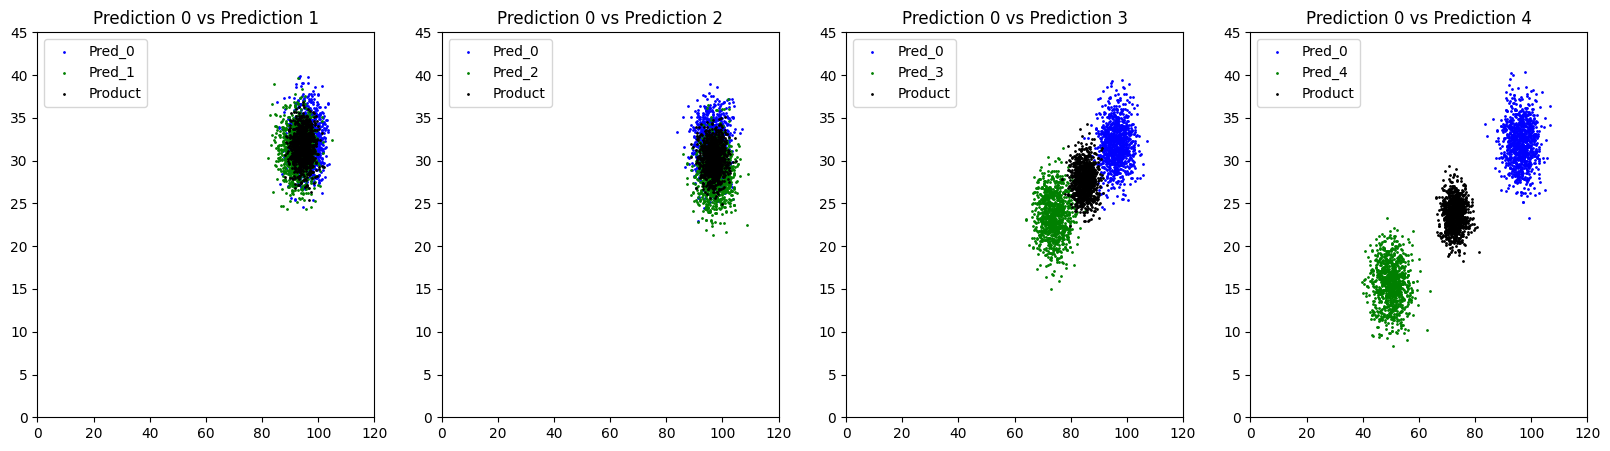

In [24]:
# Inverse Hessian can be used as covariance of the Gaussian
covA = np.linalg.inv(tag0HessInv[0][2:5,2:5])
# Maximum-likelihood estimation gives the mean of the Gaussian
meanA = tag0X[0][2:5]

_, ax = plt.subplots(1, 4, figsize=(20, 5))
plt.setp(ax, xlim=(0, 120), ylim=(0, 45))
plt.title("Product of Gaussian densities of")
for i in range(1, 5):
    covB = np.linalg.inv(tag0HessInv[i][2:5,2:5])
    meanB = tag0X[i][2:5]

    x = mvn(meanA, covA, 1000)
    ax[i-1].scatter(x[:,0], x[:,1], 1, color='b', label="Pred_0")
    x = mvn(meanB, covB, 1000)
    ax[i-1].scatter(x[:,0], x[:,1], 1, color='g', label="Pred_"+str(i))

    covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
    meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))
    x = mvn(meanC, covC, 1000)
    ax[i-1].scatter(x[:,0], x[:,1], 1, color='black', label="Product")
    ax[i-1].set_title("Prediction 0 vs Prediction "+str(i))
    ax[i-1].legend()

In [25]:
print(meanA)

[96.15 32.01 64.82]


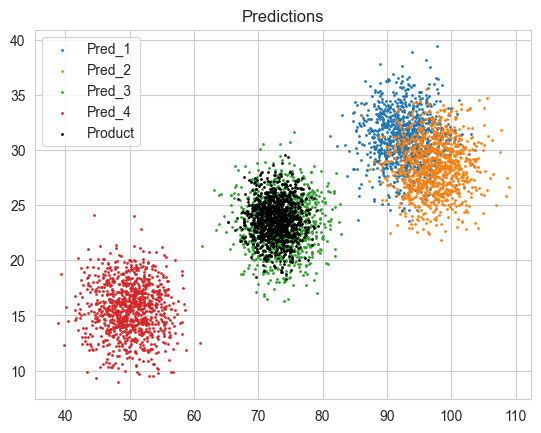

In [212]:
# Inverse Hessian can be used as covariance of the Gaussian
covA = np.linalg.inv(tag0HessInv[0][2:5,2:5])
# Maximum-likelihood estimation gives the mean of the Gaussian
meanA = tag0X[0][2:5]
#meanA = tag0X[0]

#plt.setp(ax, xlim=(0, 120), ylim=(0, 45))
plt.title("Product of Gaussian densities of")
for i in range(1, 5):
    covB = np.linalg.inv(tag0HessInv[i][2:5,2:5])
    meanB = tag0X[i][2:5]


    x = mvn(meanB, covB, 1000)
    plt.scatter(x[:,0], x[:,1], 1, label="Pred_"+str(i))

    covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
    meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))



x = mvn(meanC, covC, 1000)
plt.scatter(x[:,0], x[:,1], 1, color='black', label="Product")

plt.title("Predictions")
plt.legend()

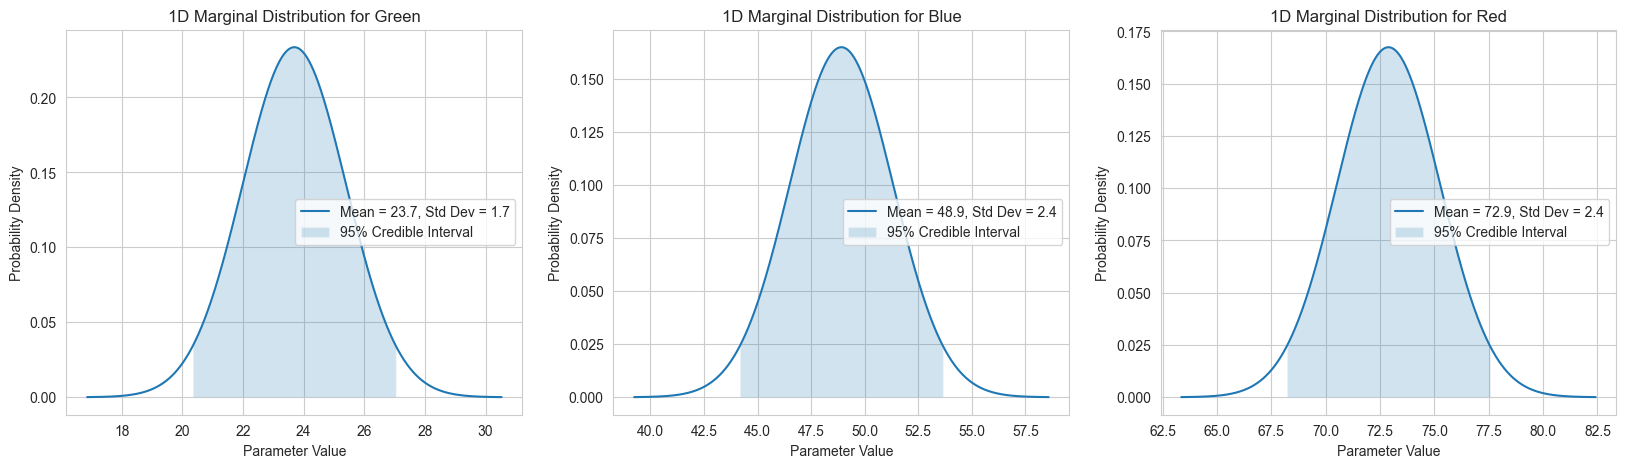

In [213]:
# Set plot style
sns.set_style("whitegrid")

# --- Define Model Parameters ---
mean = meanC
cov_matrix = covC
param_labels = ['Red', 'Green', 'Blue']

_, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.title("Product of Gaussian densities of")
for i in range(3):

    mu1 = mean[i]
    sigma1 = np2.sqrt(cov_matrix[i, i])

    # Generate x-values for the plot
    x = np2.linspace(mu1 - 4 * sigma1, mu1 + 4 * sigma1, 1000)
    pdf = norm.pdf(x, mu1, sigma1)

    ax[i-1].plot(x, pdf, label=f'Mean = {mu1:.1f}, Std Dev = {sigma1:.1f}')

    # Shade the 95% credible interval
    x_fill = np2.linspace(mu1 - 1.96 * sigma1, mu1 + 1.96 * sigma1, 100)
    y_fill = norm.pdf(x_fill, mu1, sigma1)
    ax[i-1].fill_between(x_fill, y_fill, alpha=0.2, label='95% Credible Interval')

    ax[i-1].set_title(f'1D Marginal Distribution for {param_labels[i]}')
    ax[i-1].set_xlabel('Parameter Value')
    ax[i-1].set_ylabel('Probability Density')
    ax[i-1].legend()


In [105]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern

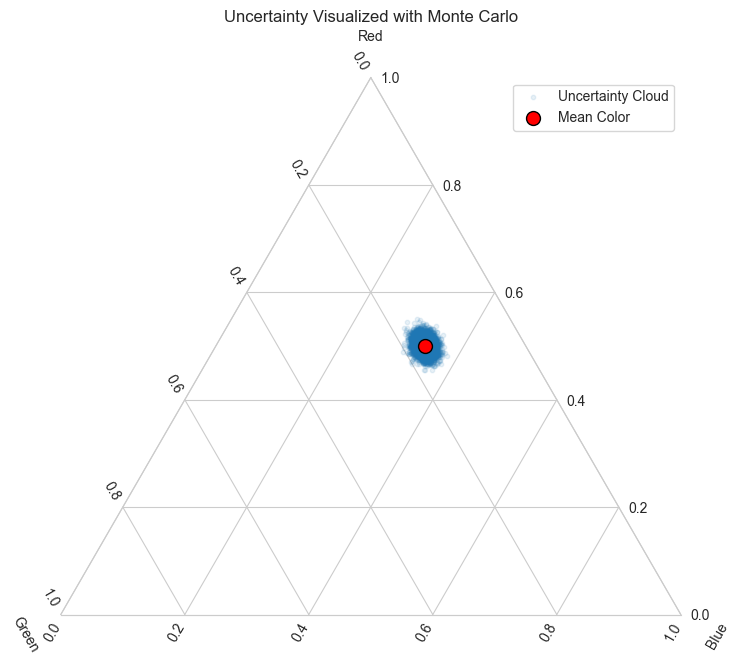

In [221]:
import matplotlib.pyplot as plt
import numpy as np
# mpltern is required for the 'ternary' projection
# 1. PREPARE YOUR DATA
# The mean R, G, B values (must sum to 1.0 for a standard ternary plot)
mean_color = mean
# The 3x3 covariance matrix
# Note the large negative covariance between R and G (-0.01)
cov_matrix = cov_matrix


# 2. GENERATE AND PLOT
# Generate 5000 random samples based on the mean and covariance
# This creates the data for our uncertainty "cloud"
n_samples = 5000
#samples = np.random.multivariate_normal(mean_color, cov_matrix, size=n_samples)
samples = mvn(mean_color, cov_matrix, size=n_samples)

# Normalize samples to ensure they sum to 1, as values can be negative
# or outside the standard range after random generation.
samples = np.abs(samples) # Take absolute value to handle potential negatives
samples /= samples.sum(axis=1)[:, np.newaxis]

# Extract the R, G, B components for plotting
r_samples, g_samples, b_samples = samples.T


# --- Your Framework ---
# Note: ternary_sum is changed to 1.0, which is standard for compositions
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='ternary', ternary_sum=1.0)

# Plot the uncertainty cloud
ax.scatter(r_samples, g_samples, b_samples, alpha=0.1, s=10.0, label='Uncertainty Cloud')

# Plot the mean point on top so it's clearly visible
ax.scatter(mean_color[0], mean_color[1], mean_color[2],
           s=100.0, c="red", edgecolors="k", zorder=10, label='Mean Color')

ax.set_title("Uncertainty Visualized with Monte Carlo")
ax.set_tlabel("Red")
ax.set_llabel("Green")
ax.set_rlabel("Blue")

ax.grid(True)
ax.legend()
plt.show()

In [305]:
import scipy
n_samples = 100000
levels = [0, 34, 66, 95, 100] 

samples = mvn(mean_color, cov_matrix, size=n_samples)
samples = np.abs(samples)
samples /= samples.sum(axis=1)[:, np.newaxis]
r_samples, g_samples, b_samples = samples.T
entropy_samples = np.apply_along_axis(scipy.stats.entropy, 1, samples, qk=mean, base=3) * 20000

<Figure size 1080x480 with 0 Axes>

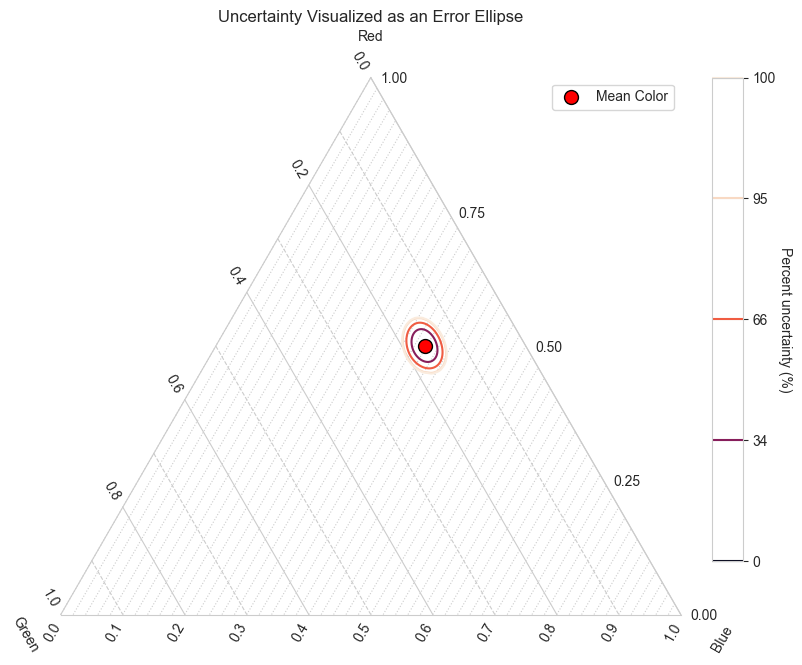

In [306]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)


# --- Framework ---
fig = plt.figure(figsize=(8, 8))
bax = fig.add_subplot(projection='ternary', ternary_sum=1.0)
cs = bax.tricontour(r_samples, g_samples, b_samples, entropy_samples, levels=levels)
bax.set_title("tricontour")

cax = bax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=bax.transAxes)
colorbar = fig.colorbar(cs, cax=cax)
colorbar.set_label('Percent uncertainty (%)', rotation=270, va='baseline')

# Plot the mean point so it's clearly visible
bax.scatter(mean_color[0], mean_color[1], mean_color[2],
           s=100.0, c="red", edgecolors="k", zorder=10, label='Mean Color')

bax.taxis.set_major_locator(MultipleLocator(0.25))
bax.laxis.set_major_locator(MultipleLocator(0.20))
bax.raxis.set_major_locator(MultipleLocator(0.10))

bax.laxis.set_minor_locator(MultipleLocator(0.1))
bax.raxis.set_minor_locator(AutoMinorLocator(5))

bax.grid(axis='t')
bax.grid(axis='l', which='minor', linestyle='--')
bax.grid(axis='r', which='both', linestyle=':')

bax.set_title("Uncertainty Visualized as an Error Ellipse")
bax.set_tlabel("Red")
bax.set_llabel("Green")
bax.set_rlabel("Blue")

bax.legend()
plt.show()